Day 37 : 21.03.12

# Simple Feature Engg Notebook - Spooky Author

https://www.kaggle.com/sudalairajkumar/simple-feature-engg-notebook-spooky-author

이 대회의 데이터셋은 다음과 같은 유명하고 무서운 저자들이 쓴 소설 작품의 텍스트를 포함한다.
1. Edgar Allen Poe (EAP)
2. HP Lovecraft (HPL)
3. Mary Wollstonecraft Shelley (MWS)

이 커널에선 무서운 작가를 식별하는 데 도움이 되는 다양한 변수를 만들어본다. 첫 단계로, feature engineering 파트에 깊이 들어가기 전, 몇 가지 기본적인 데이터 시각화 및 전처리를 수행한다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import string
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import ensemble, metrics, model_selection, naive_bayes
color = sns.color_palette()

%matplotlib inline

eng_stopwords = set(stopwords.words('english'))
pd.options.mode.chained_assignment = None

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')
print('Number of rows in train dataset : ', train_df.shape[0])
print('Number of rows in test dataset : ', test_df.shape[0])

Number of rows in train dataset :  19579
Number of rows in test dataset :  8392


In [4]:
train_df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


클래스가 균형적인지 보기 위해 각 저자의 발생 횟수를 확인할 수 있다.

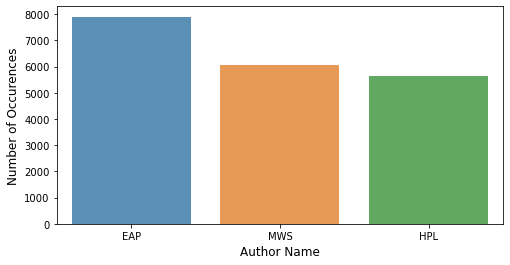

In [8]:
cnt_srs = train_df['author'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurences', fontsize=12)
plt.xlabel('Author Name', fontsize=12)
plt.show()

클래스의 불균형이 심하지 않다. 각 저자의 몇 줄씩 출력해 가능하면 그들의 작문 스타일을 이해보자.

In [9]:
grouped_df = train_df.groupby('author')
for name, group in grouped_df:
    print('Author name : ', name)
    cnt = 0
    for ind, row in group.iterrows():
        print(row['text'])
        cnt += 1
        if cnt == 5:
            break
    print('\n')

Author name :  EAP
This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.
In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.
The astronomer, perhaps, at this point, took refuge in the suggestion of non luminosity; and here analogy was suddenly let fall.
The surcingle hung in ribands from my body.
I knew that you could not say to yourself 'stereotomy' without being brought to think of atomies, and thus of the theories of Epicurus; and since, when we discussed this subject not very long ago, I mentioned to you how singularly, yet with how little notice, the vague guesses of that noble Greek had met with confirmation in the late nebular cosmogony, I felt that you coul

text 데이터에 특수문자가 많다는 것을 알 수 있다. 이 특수문자들이 좋은 변수일 수 있다.

그거 말고는, 단서가 많지 않다. 

## Feature engineering

이제 feature engineering을 해보자. 두 가지 주요 부분으로 구성된다.

1. Meta features : 단어 수, 중지단어 수, 문장부호 수 등과 같은 text에서 추출되는 변수
2. Text based features : 빈도, svd, word2vec 등과 같은 텍스트/단어을 직접적 기반으로 하는 변수

### Meta Features

메타 변수를 만든느 것부터 시작해 그것들이 작가를 얼마나 잘 예측하는지 볼 것이다. 다음은 변수 목록이다.
1. 텍스트의 단어 수
2. 텍스트의 고유 단어 수
3. 텍스트의 문자 수
4. 중지단어 수
5. 구두점 수
6. 대문자 수
7. 제목 수
8. 단어 평균 길이

In [16]:
# 1. 텍스트의 단어 수
train_df['num_words'] = train_df['text'].apply(lambda x: len(str(x).split()))
test_df['num_words'] = test_df['text'].apply(lambda x:  len(str(x).split()))

# 2. 텍스트의 고유 단어 수
train_df['num_unique_words'] = train_df['text'].apply(lambda x: len(set(str(x).split())))
test_df['num_unique_words'] = test_df['text'].apply(lambda x: len(set(str(x).split())))

# 3. 텍스트의 문자 수
train_df['num_chars'] = train_df['text'].apply(lambda x: len(str(x)))
test_df['num_chars'] = test_df['text'].apply(lambda x: len(str(x)))

# 4. 텍스트의 중지단어 수
train_df['num_stopwords'] = train_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
test_df['num_stopwords'] = test_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

# 5. 텍스트의 구두점 수
train_df['num_punctuations'] = train_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
test_df['num_punctuations'] = test_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# 6. 텍스트의 대문자 수
train_df['num_words_upper'] = train_df['text'].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test_df['num_words_upper'] = test_df['text'].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

# 7. 텍스트의 제목 수
train_df['num_words_title'] = train_df['text'].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test_df['num_words_title'] = test_df['text'].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

# 8. 텍스트의 단어 평균 길이
train_df['mean_word_len'] = train_df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df['mean_word_len'] = test_df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

이제 예측에 도움이 될지 보기 위해 새로운 변수 중 일부를 시각화해보자.

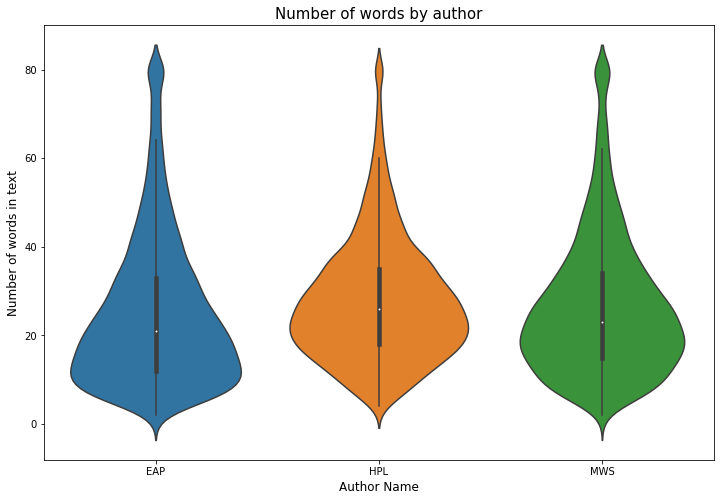

In [18]:
train_df['num_words'].loc[train_df['num_words']>80] = 80 # 더 나은 시각화 위해
plt.figure(figsize=(12,8))
sns.violinplot(x='author', y='num_words', data=train_df)
plt.xlabel('Author Name', fontsize=12)
plt.ylabel('Number of words in text', fontsize=12)
plt.title('Number of words by author', fontsize=15)
plt.show()

EAP는 MWS나 HPL보다 단어 수가 약간 적어보인다.

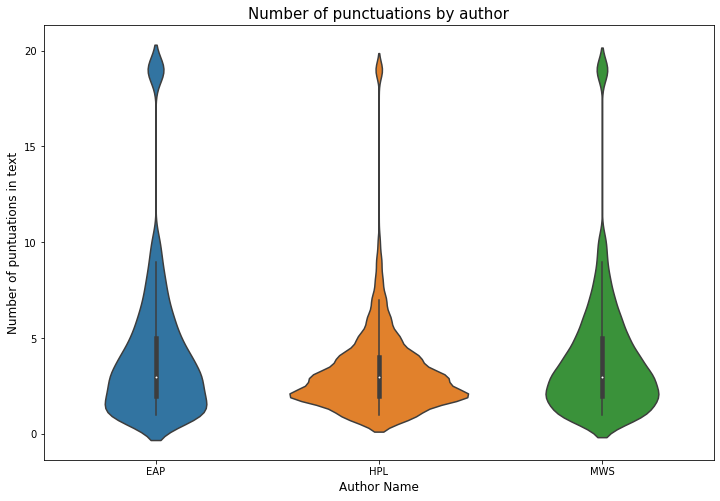

In [19]:
train_df['num_punctuations'].loc[train_df['num_punctuations']>10] = 19
plt.figure(figsize=(12,8))
sns.violinplot(x='author', y='num_punctuations', data=train_df)
plt.xlabel('Author Name', fontsize=12)
plt.ylabel('Number of puntuations in text', fontsize=12)
plt.title("Number of punctuations by author", fontsize=15)
plt.show()

다소 유용해보인다. 이제 텍스트 기반 변수를 만드는 데 초점을 두자. 먼저 이렇나 메타 변수가 어떻게 도움이 되는지 볼 수 있는 기본 모델을 구축한다.

In [20]:
# 모델링 위한 데이터 준비
author_mapping_dict = {'EAP':0, 'HPL':1, 'MWS':2}
train_y = train_df['author'].map(author_mapping_dict)
train_id = train_df['id'].values
test_id = test_df['id'].values

# 잘라낸 변수 다시 계산
train_df['num_words'] = train_df['text'].apply(lambda x: len(str(x).split()))
test_df["num_words"] = test_df["text"].apply(lambda x: len(str(x).split()))
train_df["mean_word_len"] = train_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df["mean_word_len"] = test_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

cols_to_drop = ['id','text']
train_X = train_df.drop(cols_to_drop+['author'], axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

이 메타 변수만으로 XGBoost를 학습시킬 수 있다.

In [21]:
def runXGB(train_X, train_y, test_X, test_y=None, test_X2=None, seed_val=0, child=1, colsample=0.3):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.1
    param['max_depth'] = 3
    param['silent'] = 1
    param['num_class'] = 3
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = child
    param['subsample'] = 0.8
    param['colsample_bytree'] = colsample
    param['seed'] = seed_val
    num_rounds = 2000
    
    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)
    
    if test_y is not None:
        xgtest = xbg.DMatrix(test_X, label=test_y)
        watchlist = [(xgtrain,'train'), (xgtest,'test')]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=20)
    else:
        xgtest = xgb.Dmatrix(test_y)
        model = xgb.train(plst, xgtrain, num_rounds)
        
    pred_test_y = model.predict(xgtest, ntree_limit=model.best_ntree_limit)
    if test_X2 is not None:
        xgtest2 = xgb.DMatrix(test_X2)
        pred_test_y2 = model.predict(xgtest2, ntree_limit=model.best_ntree_limit)
        
    return pred_test_y, pred_test_y2, model